# Model Building

TODO:

-> try graph similarity network (add threshold to the correlations) -> https://gephi.org/

time series:
- recurrent ann
- pls model
- look at predicting score

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score, classification_report
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
xgb.set_config(verbosity=0)
from sklearn.feature_selection import RFECV
import random
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import balanced_accuracy_score
from sklearn import metrics
import matplotlib
from sklearn.model_selection import train_test_split 

In [8]:
# Drop first column of dataframe
def drop_first_col(df):
    return df.iloc[: , 1:]

X_train_20 = pd.read_csv("dataset\X_train_2_20.csv")
X_test_20 = pd.read_csv("dataset\X_test_2_20.csv")
y_train_20 = pd.read_csv("dataset\y_train_2_20.csv")
y_test_20 = pd.read_csv("dataset\y_test_2_20.csv")

X_train_40 = pd.read_csv("dataset\X_train_2_40.csv")
X_test_40 = pd.read_csv("dataset\X_test_2_40.csv")
y_train_40 = pd.read_csv("dataset\y_train_2_40.csv")
y_test_40 = pd.read_csv("dataset\y_test_2_40.csv")

X_train_20 = drop_first_col(X_train_20)
X_test_20 = drop_first_col(X_test_20)
y_train_20 = drop_first_col(y_train_20)
y_test_20 = drop_first_col(y_test_20)

X_train_40 = drop_first_col(X_train_40)
X_test_40 = drop_first_col(X_test_40)
y_train_40 = drop_first_col(y_train_40)
y_test_40 = drop_first_col(y_test_40)

## Test on single simple models

### Single XGB Classifier (with no hyperparameters selection)

In [1]:
def XGB_class(X_train, X_test, y_train, y_test,learning_rate, n_estimators, max_depth,min_child_weight, gamma, subsample, colsample_bytree, simple):
    
    if simple:
        clf = xgb.XGBClassifier(seed = 24, use_label_encoder =False)
    else:
        clf = xgb.XGBClassifier(learning_rate = learning_rate, n_estimators = int(n_estimators), max_depth = int(max_depth), 
                                min_child_weight = min_child_weight, gamma = gamma, subsample = subsample, 
                                colsample_bytree = colsample_bytree, seed = 24,eval_metric='mlogloss',use_label_encoder =False)

    clf.fit(X_train, y_train)
    y_predicted = clf.predict(X_test)

    print(classification_report(y_test, y_predicted))
    print("Accuracy:", accuracy_score(y_test, y_predicted))
    print("MCC =",matthews_corrcoef(y_test, y_predicted))
    print("AUC =",metrics.roc_auc_score(y_test, y_predicted))
    
    return clf.predict_proba(X_test)[:,1]

In [4]:
sXGBc_y_predicted_20 = XGB_class(X_train_20,X_test_20,y_train_20,y_test_20,0,0,0,0,0,0,0,simple=True)
sXGBc_y_predicted_40 = XGB_class(X_train_40,X_test_40,y_train_40,y_test_40,0,0,0,0,0,0,0,simple=True)

              precision    recall  f1-score   support

           0       0.50      0.50      0.50        10
           1       0.71      0.71      0.71        17

    accuracy                           0.63        27
   macro avg       0.60      0.60      0.60        27
weighted avg       0.63      0.63      0.63        27

Accuracy: 0.6296296296296297
MCC = 0.20588235294117646
AUC = 0.6029411764705883
              precision    recall  f1-score   support

           0       0.56      0.43      0.49        21
           1       0.68      0.79      0.73        33

    accuracy                           0.65        54
   macro avg       0.62      0.61      0.61        54
weighted avg       0.64      0.65      0.64        54

Accuracy: 0.6481481481481481
MCC = 0.23108558332704238
AUC = 0.6082251082251082


### SVM

In [5]:
def sSVMc(X_train,X_test,y_train,y_test):
    clf = SVC(kernel='linear',probability=True) 
    clf.fit(X_train, y_train) 
    preds = clf.predict(X_test)
    sSVM_y_predicted = clf.predict_proba(X_test)[:,1]
    
    print(classification_report(y_test, preds))
    print("Accuracy:", accuracy_score(y_test, preds))
    print("MCC =",matthews_corrcoef(y_test, preds))
    
    return sSVM_y_predicted

In [6]:
print('Using 20% as test subset:')
sSVM_y_predicted_20 = sSVMc(X_train_20,X_test_20,y_train_20,y_test_20)
print('Using 40% as test subset:')
sSVM_y_predicted_40 = sSVMc(X_train_40,X_test_40,y_train_40,y_test_40)

Using 20% as test subset:
              precision    recall  f1-score   support

           0       0.45      0.50      0.48        10
           1       0.69      0.65      0.67        17

    accuracy                           0.59        27
   macro avg       0.57      0.57      0.57        27
weighted avg       0.60      0.59      0.60        27

Accuracy: 0.5925925925925926
MCC = 0.1445304031446501
Using 40% as test subset:
              precision    recall  f1-score   support

           0       0.72      0.62      0.67        21
           1       0.78      0.85      0.81        33

    accuracy                           0.76        54
   macro avg       0.75      0.73      0.74        54
weighted avg       0.76      0.76      0.76        54

Accuracy: 0.7592592592592593
MCC = 0.48349377841522817


C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Single Random Forest classifier

In [7]:
def sRFC(X_train,X_test,y_train,y_test):
    model = RandomForestClassifier().fit(X_train,y_train)
    preds = model.predict(X_test)
    sRFC_y_predicted = model.predict_proba(X_test)[:,1]
    
    print(classification_report(y_test, preds))
    print("Accuracy:", accuracy_score(y_test, preds))
    print("MCC =",matthews_corrcoef(y_test, preds))
    
    return sRFC_y_predicted

In [17]:
print('Using 20% as test subset:')
sRFC_y_predicted_20 = sRFC(X_train_20,X_test_20,y_train_20,y_test_20)
print('Using 40% as test subset:')
sRFC_y_predicted_40 = sRFC(X_train_40,X_test_40,y_train_40,y_test_40)

Using 20% as test subset:
              precision    recall  f1-score   support

           0       0.44      0.40      0.42        10
           1       0.67      0.71      0.69        17

    accuracy                           0.59        27
   macro avg       0.56      0.55      0.55        27
weighted avg       0.58      0.59      0.59        27

Accuracy: 0.5925925925925926
MCC = 0.1084652289093281
Using 40% as test subset:


C:\Users\marti\AppData\Local\Temp\ipykernel_17196\779422996.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestClassifier().fit(X_train,y_train)
C:\Users\marti\AppData\Local\Temp\ipykernel_17196\779422996.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestClassifier().fit(X_train,y_train)


              precision    recall  f1-score   support

           0       0.45      0.24      0.31        21
           1       0.63      0.82      0.71        33

    accuracy                           0.59        54
   macro avg       0.54      0.53      0.51        54
weighted avg       0.56      0.59      0.56        54

Accuracy: 0.5925925925925926
MCC = 0.06811886754686414


### Logistic Regression

In [9]:
def sLR(X_train,X_test,y_train,y_test):
    model = LogisticRegression(random_state=0).fit(X_train,y_train)
    preds = model.predict(X_test)
    sLR_y_predicted = model.predict_proba(X_test)[:,1]
    
    print(classification_report(y_test, preds))
    print("Accuracy:", accuracy_score(y_test, preds))
    print("MCC =",matthews_corrcoef(y_test, preds))
    
    return sLR_y_predicted

In [10]:
print('Using 20% as test subset:')
sLR_y_predicted_20 = sLR(X_train_20,X_test_20,y_train_20,y_test_20)
print('Using 40% as test subset:')
sLR_y_predicted_40 = sLR(X_train_40,X_test_40,y_train_40,y_test_40)

Using 20% as test subset:
              precision    recall  f1-score   support

           0       0.45      0.50      0.48        10
           1       0.69      0.65      0.67        17

    accuracy                           0.59        27
   macro avg       0.57      0.57      0.57        27
weighted avg       0.60      0.59      0.60        27

Accuracy: 0.5925925925925926
MCC = 0.1445304031446501
Using 40% as test subset:
              precision    recall  f1-score   support

           0       0.67      0.48      0.56        21
           1       0.72      0.85      0.78        33

    accuracy                           0.70        54
   macro avg       0.69      0.66      0.67        54
weighted avg       0.70      0.70      0.69        54

Accuracy: 0.7037037037037037
MCC = 0.3533767463701098


C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\marti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

## Features Selection

### Recursive Feature Elimination (RFE)

In [2]:
def rfe_xgb(X_train, y_train,X_test,learning_rate, n_estimators, max_depth,min_child_weight, gamma, subsample, colsample_bytree, simple):
    min_features_to_select = 55
    
    #run RFE on current train subset
    if simple:
        clf = xgb.XGBClassifier(seed = 24, use_label_encoder =False)
    else:
        clf = xgb.XGBClassifier(learning_rate = learning_rate, n_estimators = int(n_estimators), max_depth = int(max_depth), 
                                min_child_weight = min_child_weight, gamma = gamma, subsample = subsample, 
                                colsample_bytree = colsample_bytree, seed = 24,eval_metric='mlogloss',use_label_encoder =False)
    rfecv = RFECV(estimator=clf,min_features_to_select=min_features_to_select,step=3,n_jobs=-1,scoring="r2",cv=5)
    rfecv.fit(X_train, y_train)
    
    #keep selected features + check RFE accuracy scores during running
    newX_train = X_train[X_train.columns[rfecv.support_]]
    newX_test = X_test[X_test.columns[rfecv.support_]]
    print('We kept',newX_train.shape[1],'features out of the',X_train.shape[1])
    
    return newX_train,newX_test

### Test on single XGB classifier using RFE selected features

In [12]:
#test rfe then simple XGB classifier
newX_train,newX_test = rfe_xgb(X_train_20, y_train_20,X_test_20,0,0,0,0,0,0,0,simple=True)
RFE_XGB_y_predicted = XGB_class(newX_train,newX_test,y_train_20,y_test_20,0,0,0,0,0,0,0,simple=True)

We kept 56 features out of the 320
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.82      0.82      0.82        17

    accuracy                           0.78        27
   macro avg       0.76      0.76      0.76        27
weighted avg       0.78      0.78      0.78        27

Accuracy: 0.7777777777777778
MCC = 0.5235294117647059
AUC = 0.7617647058823529


### Test on single SVM classifier using RFE selected features

In [13]:
min_features_to_select = 199

#run RFE on current train subset
clf = SVC(kernel='linear',probability=True) 

rfecv = RFECV(estimator=clf,min_features_to_select=min_features_to_select,step=3,n_jobs=-1,scoring="r2",cv=5)
rfecv.fit(X_train_40, y_train_40.values.ravel())

#keep selected features + check RFE accuracy scores during running
newX_train = X_train_40[X_train_40.columns[rfecv.support_]]
newX_test = X_test_40[X_test_40.columns[rfecv.support_]]
print('We kept',newX_train.shape[1],'features out of the',X_train_40.shape[1])
  
# fitting x samples and y classes 
clf.fit(newX_train, y_train_40) 
preds = clf.predict(newX_test)
RFE_SVM_y_predicted = clf.predict_proba(newX_test)[:,1]

print(classification_report(y_test_40, preds))
print("Accuracy:", accuracy_score(y_test_40, preds))
print("MCC =",matthews_corrcoef(y_test_40, preds))
print("AUC =",metrics.roc_auc_score(y_test_40, preds))

We kept 200 features out of the 320
              precision    recall  f1-score   support

           0       0.76      0.62      0.68        21
           1       0.78      0.88      0.83        33

    accuracy                           0.78        54
   macro avg       0.77      0.75      0.76        54
weighted avg       0.78      0.78      0.77        54

Accuracy: 0.7777777777777778
MCC = 0.5225491613224563
AUC = 0.748917748917749


C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Plot AUC-ROC Curve

In [79]:
def roc(y_tests,y_predicted,models_name,title):  
    if len(y_predicted)>2:  
        #there are 4 diff colors in max
        colors = ["red", "blue", "green", "orange"]
            
        for i in range(int(len(y_predicted)/2)):
            fpr, tpr, _ = metrics.roc_curve(y_tests[i],  y_predicted[i])
            #create ROC curve
            plt.plot(fpr, tpr, linestyle='-',color=colors[i])

        counter=0
        for i in range(int(len(y_predicted)/2),int(len(y_predicted))):
            fpr, tpr, _ = metrics.roc_curve(y_tests[i],  y_predicted[i])
            #create ROC curve
            plt.plot(fpr, tpr, linestyle='--',color=colors[counter])
            counter+=1
    
    else:
        for i in range(int(len(y_predicted))):
            fpr, tpr, _ = metrics.roc_curve(y_tests[i],  y_predicted[i])
            #create ROC curve
            plt.plot(fpr, tpr, linestyle='-')
    
        
    plt.legend(models_name)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(title)
    plt.show()

C:\Users\marti\AppData\Local\Temp\ipykernel_17196\921600576.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_tests = np.array([y_test_20,y_test_40])
C:\Users\marti\AppData\Local\Temp\ipykernel_17196\921600576.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_preds = np.array([RFE_XGB_y_predicted,RFE_SVM_y_predicted])


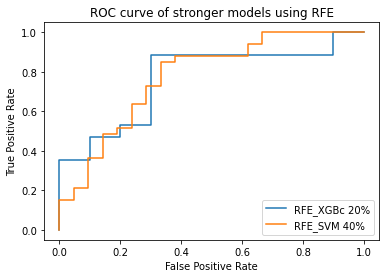

In [80]:
y_tests = np.array([y_test_20,y_test_40])
y_preds = np.array([RFE_XGB_y_predicted,RFE_SVM_y_predicted])
models_name=np.array(['RFE_XGBc 20%','RFE_SVM 40%'])
title = 'ROC curve of stronger models using RFE'
roc(y_tests,y_preds,models_name,title)

C:\Users\marti\AppData\Local\Temp\ipykernel_17196\2862004269.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_tests = np.array([y_test_20,y_test_20,y_test_20,y_test_20,y_test_40,y_test_40,y_test_40,y_test_40])
C:\Users\marti\AppData\Local\Temp\ipykernel_17196\2862004269.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_preds = np.array([sXGBc_y_predicted_20,sSVM_y_predicted_20,sRFC_y_predicted_20,sLR_y_predicted_20,sXGBc_y_predicted_40,sSVM_y_predicted_40,sRFC_y_predicted_40,sLR_y_predicted_40])


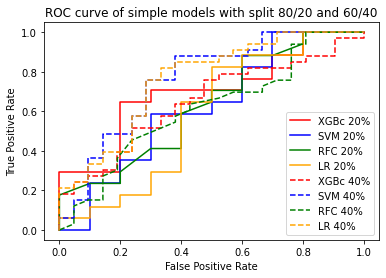

In [81]:
y_tests = np.array([y_test_20,y_test_20,y_test_20,y_test_20,y_test_40,y_test_40,y_test_40,y_test_40])
y_preds = np.array([sXGBc_y_predicted_20,sSVM_y_predicted_20,sRFC_y_predicted_20,sLR_y_predicted_20,sXGBc_y_predicted_40,sSVM_y_predicted_40,sRFC_y_predicted_40,sLR_y_predicted_40])
models_name=np.array(['XGBc 20%','SVM 20%','RFC 20%','LR 20%','XGBc 40%','SVM 40%','RFC 40%','LR 40%'])
title = 'ROC curve of simple models with split 80/20 and 60/40'
roc(y_tests,y_preds,models_name,title)

## Hyperparameter tuning XGBoost classifier

### Using Evolutionary Computation

In [17]:
random.seed(723)
np.random.seed(723)

def initilialize_poplulation(numberOfParents):
    learningRate = np.empty([numberOfParents, 1])
    nEstimators = np.empty([numberOfParents, 1], dtype = np.uint8)
    maxDepth = np.empty([numberOfParents, 1], dtype = np.uint8)
    minChildWeight = np.empty([numberOfParents, 1])
    gammaValue = np.empty([numberOfParents, 1])
    subSample = np.empty([numberOfParents, 1])
    colSampleByTree =  np.empty([numberOfParents, 1])

    for i in range(numberOfParents):
        learningRate[i] = round(random.uniform(0.01, 1), 2)
        nEstimators[i] = random.randrange(10, 1500, step = 25)
        maxDepth[i] = int(random.randrange(1, 10, step= 1))
        minChildWeight[i] = round(random.uniform(0.01, 10.0), 2)
        gammaValue[i] = round(random.uniform(0.01, 10.0), 2)
        subSample[i] = round(random.uniform(0.01, 1.0), 2)
        colSampleByTree[i] = round(random.uniform(0.01, 1.0), 2)
    
    population = np.concatenate((learningRate, nEstimators, maxDepth, minChildWeight, gammaValue, subSample, colSampleByTree), axis= 1)
    return population

   

def fitness_accuracy_score(y_true, y_pred):
    fitness = round((accuracy_score(y_true, y_pred)), 4)
    return fitness

def train_population(population, dMatrixTrain, dMatrixtest, y_test):
    aScore = []
    for i in range(population.shape[0]):
        param = { 'objective':'binary:logistic',
              'learning_rate': population[i][0],
              'n_estimators': population[i][1], 
              'max_depth': int(population[i][2]), 
              'min_child_weight': population[i][3],
              'gamma': population[i][4], 
              'subsample': population[i][5],
              'colsample_bytree': population[i][6],
              'seed': 24}
        num_round = 100
        xgbT = xgb.train(param, dMatrixTrain, num_round)
        preds = xgbT.predict(dMatrixtest)
        preds = preds>0.5
        aScore.append(fitness_accuracy_score(y_test, preds))
    return aScore



def new_parents_selection(population, fitness, numParents):
    selectedParents = np.empty((numParents, population.shape[1])) 
    
    for parentId in range(numParents):
        bestFitnessId = np.where(fitness == np.max(fitness))
        bestFitnessId  = bestFitnessId[0][0]
        selectedParents[parentId, :] = population[bestFitnessId, :]
        fitness[bestFitnessId] = -1 
    return selectedParents
        

def crossover_uniform(parents, childrenSize):
    
    crossoverPointIndex = np.arange(0, np.uint8(childrenSize[1]), 1, dtype= np.uint8)
    crossoverPointIndex1 = np.random.randint(0, np.uint8(childrenSize[1]), np.uint8(childrenSize[1]/2)) 
    crossoverPointIndex2 = np.array(list(set(crossoverPointIndex) - set(crossoverPointIndex1))) 
    
    children = np.empty(childrenSize)
    
    
    for i in range(childrenSize[0]):
        
        parent1_index = i%parents.shape[0]
        parent2_index = (i+1)%parents.shape[0]
        children[i, crossoverPointIndex1] = parents[parent1_index, crossoverPointIndex1]
        children[i, crossoverPointIndex2] = parents[parent2_index, crossoverPointIndex2]
    return children
    


def mutation(crossover, numberOfParameters):

    minMaxValue = np.zeros((numberOfParameters, 2))
    
    minMaxValue[0:] = [0.01, 1.0] 
    minMaxValue[1, :] = [10, 2000] 
    minMaxValue[2, :] = [1, 15] 
    minMaxValue[3, :] = [0, 10.0] 
    minMaxValue[4, :] = [0.01, 10.0] 
    minMaxValue[5, :] = [0.01, 1.0] 
    minMaxValue[6, :] = [0.01, 1.0] 
 
    
    mutationValue = 0
    parameterSelect = np.random.randint(0, 7, 1)
    print(parameterSelect)
    if parameterSelect == 0: 
        mutationValue = round(np.random.uniform(-0.5, 0.5), 2)
    if parameterSelect == 1: 
        mutationValue = np.random.randint(-200, 200, 1)
    if parameterSelect == 2:
        mutationValue = np.random.randint(-5, 5, 1)
    if parameterSelect == 3: 
        mutationValue = round(np.random.uniform(5, 5), 2)
    if parameterSelect == 4: 
        mutationValue = round(np.random.uniform(-2, 2), 2)
    if parameterSelect == 5: 
        mutationValue = round(np.random.uniform(-0.5, 0.5), 2)
    if parameterSelect == 6: 
        mutationValue = round(np.random.uniform(-0.5, 0.5), 2)
  
    
    for idx in range(crossover.shape[0]):
        crossover[idx, parameterSelect] = crossover[idx, parameterSelect] + mutationValue
        if(crossover[idx, parameterSelect] > minMaxValue[parameterSelect, 1]):
            crossover[idx, parameterSelect] = minMaxValue[parameterSelect, 1]
        if(crossover[idx, parameterSelect] < minMaxValue[parameterSelect, 0]):
            crossover[idx, parameterSelect] = minMaxValue[parameterSelect, 0]    
    return crossover

In [18]:
def hyp_param_ev_algo(X_train, y_train):
    
    hyp_X_train, hyp_X_test, hyp_y_train, hyp_y_test = train_test_split(X_train, y_train, test_size = 0.80, random_state = 97,stratify=y_train)

    xgDMatrix = xgb.DMatrix(hyp_X_train, hyp_y_train) 
    xgbDMatrixTest = xgb.DMatrix(hyp_X_test, hyp_y_test)

    numberOfParents = 100 
    numberOfParentsMating = int(numberOfParents/2)
    numberOfParameters = 7 
    numberOfGenerations = 5

    populationSize = (numberOfParents, numberOfParameters)
    population = initilialize_poplulation(numberOfParents)

    fitnessHistory = np.empty([numberOfGenerations+1, numberOfParents])
    populationHistory = np.empty([(numberOfGenerations+1)*numberOfParents, numberOfParameters])
    populationHistory[0:numberOfParents, :] = population

    for generation in range(numberOfGenerations):
        print("This is number %s generation" % (generation))

        fitnessValue = train_population(population=population, dMatrixTrain=xgDMatrix, dMatrixtest=xgbDMatrixTest, y_test=hyp_y_test)
        fitnessHistory[generation, :] = fitnessValue

        print('Best Accuracy score in the this iteration = {}'.format(np.max(fitnessHistory[generation, :])))

        parents = new_parents_selection(population=population, fitness=fitnessValue, numParents=numberOfParentsMating)
        children = crossover_uniform(parents=parents, childrenSize=(populationSize[0] - parents.shape[0], numberOfParameters))
        children_mutated = mutation(children, numberOfParameters)

        population[0:parents.shape[0], :] = parents 
        population[parents.shape[0]:, :] = children_mutated 

        populationHistory[(generation+1)*numberOfParents : (generation+1)*numberOfParents+ numberOfParents , :] = population 

    fitness = train_population(population=population, dMatrixTrain=xgDMatrix, dMatrixtest=xgbDMatrixTest, y_test=hyp_y_test)
    fitnessHistory[generation+1, :] = fitness

    bestFitnessIndex = np.where(fitness == np.max(fitness))[0][0]

    print("Best fitness is =", fitness[bestFitnessIndex])


    print("Best parameters are:")
    print('learning_rate', population[bestFitnessIndex][0])
    print('n_estimators', population[bestFitnessIndex][1])
    print('max_depth', int(population[bestFitnessIndex][2])) 
    print('min_child_weight', population[bestFitnessIndex][3])
    print('gamma', population[bestFitnessIndex][4])
    print('subsample', population[bestFitnessIndex][5])
    print('colsample_bytree', population[bestFitnessIndex][6])
    
    return population[bestFitnessIndex][0],population[bestFitnessIndex][1],population[bestFitnessIndex][2],population[bestFitnessIndex][3],population[bestFitnessIndex][4],population[bestFitnessIndex][5],population[bestFitnessIndex][6]

### BACKWARD ORDER) First RFE, then tuning hyperparameters on selected features

In [20]:
#test tuning XGB hyperparameters with selected features from RFE
print('1) RFE:')
newX_train,newX_test = rfe_xgb(X_train_20, y_train_20,X_test_20,0,0,0,0,0,0,0,simple=True)
print('2) XGB with RFE features:')
XGB_class(newX_train,newX_test,y_train_20,y_test_20,0,0,0,0,0,0,0,simple=True)
print('3) XGB with RFE features & Hyperparameter tuning:')
learning_rate, n_estimators, max_depth, min_child_weight,gamma, subsample,colsample_bytree = hyp_param_ev_algo(newX_train, y_train_20)
XGB_class(newX_train,newX_test,y_train_20,y_test_20,learning_rate, n_estimators, max_depth, min_child_weight,gamma, subsample,colsample_bytree,simple=False)

1) RFE:
We kept 55 features out of the 320
2) XGB with RFE features:
              precision    recall  f1-score   support

           0       0.54      0.33      0.41        21
           1       0.66      0.82      0.73        33

    accuracy                           0.63        54
   macro avg       0.60      0.58      0.57        54
weighted avg       0.61      0.63      0.61        54

Accuracy: 0.6296296296296297
MCC = 0.1727663178397569
AUC = 0.5757575757575758
3) XGB with RFE features & Hyperparameter tuning:
This is number 0 generation
Best Accuracy score in the this iteration = 0.6308
[2]
This is number 1 generation
Best Accuracy score in the this iteration = 0.6615
[2]
This is number 2 generation
Best Accuracy score in the this iteration = 0.6615
[1]
This is number 3 generation
Best Accuracy score in the this iteration = 0.6615
[2]
This is number 4 generation
Best Accuracy score in the this iteration = 0.6615
[4]
Best fitness is = 0.6615
Best parameters are:
learning_rate 

array([0.97681195, 0.9504448 , 0.08887564, 0.9966773 , 0.28388652,
       0.44971812, 0.9549236 , 0.9956986 , 0.926764  , 0.99451643,
       0.38445598, 0.01949996, 0.99955684, 0.79635763, 0.95953804,
       0.012521  , 0.99777395, 0.9520007 , 0.99780554, 0.9926092 ,
       0.3446445 , 0.06152669, 0.9964779 , 0.98794717, 0.99936146,
       0.89460325, 0.46219113, 0.63413686, 0.18690062, 0.107401  ,
       0.02426153, 0.883185  , 0.4004294 , 0.75216293, 0.03226375,
       0.46995714, 0.9227085 , 0.01888648, 0.86064315, 0.933253  ,
       0.16189152, 0.99721813, 0.99291354, 0.15769199, 0.6341477 ,
       0.38900983, 0.26742345, 0.71279335, 0.9992791 , 0.3617767 ,
       0.91224635, 0.97116405, 0.9871405 , 0.04010648], dtype=float32)

### FORWARD ORDER) First Forward feature selection, then tuning hyperparameters on selected features

In [21]:
def forward_select(X_train, y_train):
    
    acc_imp = 0  
    last_acc=0
    features_selected=[]
    
    while acc_imp>=0:
        accuracies = []
        for i in range(len(X_train)):   
            clf = xgb.XGBClassifier(seed = 24, use_label_encoder =False)
            curr_X_train = X_train.iloc[:,i]
            for j in range(len(features_selected)):
                curr_X_train = pd.concat([curr_X_train, features_selected[j]],axis=1)
            fs_X_train, fs_X_test, fs_y_train, fs_y_test = train_test_split(curr_X_train, y_train, test_size = 0.80, random_state = 97,stratify=y_train)

            clf.fit(fs_X_train, fs_y_train)
            y_predicted = clf.predict(fs_X_test)
            accuracies.append(accuracy_score(fs_y_test, y_predicted))
        
        best_feature_idx=np.argmax(accuracies) 
        print('new best feature added =',X_train.iloc[:,best_feature_idx].name)
        features_selected.append(X_train.iloc[:,best_feature_idx])
        X_train.drop(X_train.columns[best_feature_idx],axis=1,inplace=True)
        curr_acc=accuracies[best_feature_idx]
        print('new acc =',curr_acc)
        acc_imp = curr_acc-last_acc
        last_acc = curr_acc
    
    print('-> last best acc on training set =',last_acc)
    
    best_features_names = []
    for i in features_selected:
        best_features_names.append(i.name)

    return best_features_names

In [22]:
#test tuning XGB hyperparameters with selected features from forward selection
print('1) Forward feature selection:')
fs_best_features = forward_select(X_train_20.copy(), y_train_20)
newX_train = X_train_20.loc[:,fs_best_features]
newX_test = X_test_20[(newX_train.columns) & (X_test_20.columns)]
print('We kept',newX_train.shape[1],'features out of the',X_train_20.shape[1])
print('2) XGB with forward feature selection')
XGB_class(newX_train,newX_test,y_train_20,y_test_20,0,0,0,0,0,0,0,simple=True)
print('3) XGB with forward feature selection & Hyperparameter tuning:')
learning_rate, n_estimators, max_depth, min_child_weight,gamma, subsample,colsample_bytree = hyp_param_ev_algo(newX_train, y_train_20)
XGB_class(newX_train,newX_test,y_train_20,y_test_20,learning_rate, n_estimators, max_depth, min_child_weight,gamma, subsample,colsample_bytree,simple=False)

1) Forward feature selection:
new best feature added = A1BG.SGLSTGWTQLSK
new acc = 0.676923076923077
new best feature added = CAD13.DIQGSLQDIFK
new acc = 0.7230769230769231
new best feature added = AACT.EIGELYLPK
new acc = 0.7538461538461538
new best feature added = AACT.NLAVSQVVHK
new acc = 0.7538461538461538
new best feature added = ALDOA.QLLLTADDR
new acc = 0.7538461538461538
new best feature added = AATC.NLDYVATSIHEAVTK
new acc = 0.7692307692307693
new best feature added = APOE.LGADMEDVR
new acc = 0.7692307692307693
new best feature added = APLP2.HYQHVLAVDPEK
new acc = 0.7846153846153846
new best feature added = APOE.AATVGSLAGQPLQER
new acc = 0.7846153846153846
new best feature added = AATM.FVTVQTISGTGALR
new acc = 0.7846153846153846
new best feature added = CATL1.VFQEPLFYEAPR
new acc = 0.7846153846153846
new best feature added = CATA.LFAYPDTHR
new acc = 0.7692307692307693
-> last best acc on training set = 0.7692307692307693
2) XGB with forward feature selection
              prec

C:\Users\marti\AppData\Local\Temp\ipykernel_13132\599379768.py:5: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  newX_test = X_test_40[(newX_train.columns) & (X_test_40.columns)]


Best Accuracy score in the this iteration = 0.6154
[1]
This is number 1 generation
Best Accuracy score in the this iteration = 0.6154
[2]
This is number 2 generation
Best Accuracy score in the this iteration = 0.6308
[4]
This is number 3 generation
Best Accuracy score in the this iteration = 0.6462
[1]
This is number 4 generation
Best Accuracy score in the this iteration = 0.6462
[3]
Best fitness is = 0.6462
Best parameters are:
learning_rate 0.35
n_estimators 170.0
max_depth 1
min_child_weight 0.19
gamma 0.01
subsample 0.18
colsample_bytree 0.87
              precision    recall  f1-score   support

           0       0.41      0.33      0.37        21
           1       0.62      0.70      0.66        33

    accuracy                           0.56        54
   macro avg       0.52      0.52      0.51        54
weighted avg       0.54      0.56      0.54        54

Accuracy: 0.5555555555555556
MCC = 0.031807340254410385
AUC = 0.5151515151515151


array([0.71379805, 0.99635017, 0.94802505, 0.17251427, 0.19562496,
       0.99505866, 0.89054966, 0.27465025, 0.7176908 , 0.9896992 ,
       0.06328297, 0.50925314, 0.984772  , 0.72618884, 0.99723047,
       0.40752918, 0.97728026, 0.9965726 , 0.9956481 , 0.8013675 ,
       0.927859  , 0.85783523, 0.84335786, 0.5655096 , 0.9300899 ,
       0.0161663 , 0.35202765, 0.76879525, 0.87409496, 0.6756102 ,
       0.99888223, 0.13657573, 0.32930514, 0.9700206 , 0.0176949 ,
       0.9020761 , 0.98882294, 0.14499702, 0.5481513 , 0.24847345,
       0.66051376, 0.74065477, 0.17898317, 0.01239263, 0.42047468,
       0.6814608 , 0.9414659 , 0.93347335, 0.17323306, 0.78247607,
       0.98252654, 0.6269478 , 0.79131013, 0.03603172], dtype=float32)